In [11]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
    return to_datetime('199'+x,'%Y-%m')
series = read_csv('./dl_pytorch/chap07/data/SBUX.csv',header=0,parse_dates=[0],index_col=0,squeeze=True,
                  date_parser=parser)
model=ARIMA(series,order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe)

C:\Users\user\AppData\Local\Temp\ipykernel_14308\2600277882.py:9: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./dl_pytorch/chap07/data/SBUX.csv',header=0,parse_dates=[0],index_col=0,squeeze=True,
C:\Users\user\AppData\Local\Temp\ipykernel_14308\2600277882.py:9: FutureWarning: 
        Use pd.to_datetime instead.

  series = read_csv('./dl_pytorch/chap07/data/SBUX.csv',header=0,parse_dates=[0],index_col=0,squeeze=True,


AssertionError: 

7.4.1 RNN 셀 구현

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import time

In [2]:
start = time.time()
TEXT = torchtext.legacy.data.Field(lower=True,fix_length=200,batch_first=False)
LABEL = torchtext.legacy.data.Field(sequential=False)

In [3]:
from torchtext.legacy import datasets
train_data,test_data =datasets.IMDB.splits(TEXT,LABEL)

In [8]:
print(vars(train_data.examples[0]))

{'text': ['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"teachers".', 'my', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', "high's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"teachers".', 'the', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students.', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'i', 'immediately', 'recalled', '.........', 'at', '..........', 'high.', 'a', 'classic', 'line:', 'inspector:', "i'm", 'here', 'to', 'sack', 'one', 'of', '

In [11]:
import string
for example in train_data.examples:
    text = [x.lower() for x in vars(example)['text']] # 소문자
    text = [x.replace("<br","") for x in text] # <br -> 공백
    text = [''.join(c for c in s if c not in string.punctuation) for s in text] # 구두점 제거
    text = [s for s in text if s] #공백 제거
    vars(example)['text']=text

In [13]:
import random
train_data, valid_data = train_data.split(random_state=random.seed(0),split_ratio=0.8)

In [14]:
print(f'Number of training examples : {len(train_data)}')
print(f'Number of validation examples : {len(valid_data)}')
print(f'Number of testing examples:{len(test_data)}')


Number of training examples : 20000
Number of validation examples : 5000
Number of testing examples:25000


In [15]:
TEXT.build_vocab(train_data,max_size=10000,min_freq=10,vectors=None)
LABEL.build_vocab(train_data)

print(f'Unique tokens in TEXT vocabulary:{len(TEXT.vocab)}')
print(f'Unique tokens in LABEL vocabulary:{len(LABEL.vocab)}')

Unique tokens in TEXT vocabulary:10002
Unique tokens in LABEL vocabulary:3


In [16]:
print(LABEL.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000002A4CDBDFDF0>>, {'<unk>': 0, 'pos': 1, 'neg': 2})


In [17]:
BATCH_SIZE=32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_dim = 100
hidden_size = 300

train_iterator, valid_iterator,test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device
)

In [19]:
class RNNCell_Encoder(nn.Module):
    def __init__(self,input_dim,hidden_size):
        super(RNNCell_Encoder,self).__init__()
        self.rnn = nn.RNNCell(input_dim,hidden_size)

    def forward(self,inputs):
        bz = inputs.shape[1]
        ht = torch.zeros((bz,hidden_size)).to(device)
        for word in inputs:
            ht = self.rnn(word,ht) # 재귀 처리
        return ht

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.em = nn.Embedding(len(TEXT.vocab.stoi),embedding_dim)
        self.rnn = RNNCell_Encoder(embedding_dim,hidden_size)
        self.fc1 = nn.Linear(hidden_size,256)
        self.fc2 = nn.Linear(256,3)

    def forward(self,x):
        x = self.em(x)
        x = self.rnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
model = Net()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [21]:
def training(epoch,model,trainloader,validloader):
    correct = 0
    total = 0
    running_loss =0

    model.train()
    for b in trainloader:
        x,y = b.text,b.label
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct +=(y_pred==y).sum().item()
            total +=y.size(0)
            running_loss +=loss.item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct/total

    valid_correct = 0
    valid_total = 0
    valid_running_loss = 0

    model.eval()
    with torch.no_grad():
        for b in validloader:
            x,y = b.text,b.label
            x,y = x.to(device),y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            valid_correct +=(y_pred==y).sum().item()
            valid_total +=y.size(0)
            valid_running_loss +=loss.item()
    epoch_valid_loss = valid_running_loss / len(validloader.dataset)
    epoch_valid_acc = valid_correct/valid_total

    print('epoch: ',epoch,
          'loss: ',round(epoch_loss,3),
          'accuracy',round(epoch_acc,3),
          'valid_loss: ',round(epoch_valid_loss,3),
          'valid_acc : ',round(epoch_valid_acc,3))
    return epoch_loss,epoch_acc,epoch_valid_loss,epoch_valid_acc

In [22]:
epochs = 5
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_valid_loss,epoch_valid_acc = training(epoch,model,train_iterator,valid_iterator)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_acc)
end = time.time()
print(end-start)

epoch:  0 loss:  0.022 accuracy 0.497 valid_loss:  0.022 valid_acc :  0.491
epoch:  1 loss:  0.022 accuracy 0.503 valid_loss:  0.022 valid_acc :  0.515
epoch:  2 loss:  0.022 accuracy 0.513 valid_loss:  0.022 valid_acc :  0.517
epoch:  3 loss:  0.022 accuracy 0.529 valid_loss:  0.022 valid_acc :  0.517
epoch:  4 loss:  0.021 accuracy 0.532 valid_loss:  0.022 valid_acc :  0.5
2714.220121383667


In [24]:
print(torch.cuda.is_available())

False


In [1]:
import torch
import torchtext
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time

In [2]:
start = time.time()
TEXT= torchtext.legacy.data.Field(sequential=True,batch_first=True,lower=True)
LABEL = torchtext.legacy.data.Field(sequential=False,batch_first=True)

from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)
train_data, valid_data = train_data.split(split_ratio=0.8)

TEXT.build_vocab(train_data,max_size = 10000,min_freq=10,vectors=None)
LABEL.build_vocab(train_data)

BATCH_SIZE=50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
train_iterator,valid_iterator,test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device
)

In [5]:
vocab_size = len(TEXT.vocab)
n_classes = 2

In [7]:
class BasicRNN(nn.Module):
    def __init__(self,n_layers,hidden_dim,n_vocab,embed_dim,n_classes,dropout_p=0.2):
        super(BasicRNN,self).__init__()
        self.n_layers=n_layers # rnn계층 개수
        self.embed=nn.Embedding(n_vocab,embed_dim) # 워드 임베딩
        self.hidden_dim=hidden_dim
        self.dropout=nn.Dropout(dropout_p)
        self.rnn = nn.RNN(embed_dim,self.hidden_dim,num_layers=self.n_layers,batch_first=True)
        self.out=nn.Linear(self.hidden_dim,n_classes)
    def forward(self,x):
        x = self.embed(x) # 문자 ->숫자/벡터
        h_0 = self._init_state(batch_size=x.size(0)) #최초 은닉 상태 0 초기화
        x,_ = self.rnn(x,h_0) # rnn 계층,입력과 이전 은닉상태 값을 받음.
        h_t = x[:-1,:] # 마지막 나온 단어의 임베딩 값(마지막 은닉 상태)
        self.dropout(h_t)
        logit = torch.sigmoid(self.out(h_t))
        return logit

    def _init_state(self,batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers,batch_size,self.hidden_dim).zero_()

In [8]:
model = BasicRNN(n_layers=1,hidden_dim=256,n_vocab=vocab_size,embed_dim=128,n_classes=n_classes,dropout_p=0.5)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [16]:
def train(model,optimizer,train_iter):
    model.train()
    for b,batch in enumerate(train_iter):
        x,y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1) #label을 2,1에서 1,0으로 변환
        optimizer.zero_grad()

        logit=model(x)
        loss = F.cross_entropy(logit,y)
        loss.backward()
        optimizer.step()

        if b%50 == 0:
            print("Train Epoch : {}[{}/{}({:.0f}%)]\tLoss:{:.6f}".format(e,b*len(x),len(train_iter.dataset),loss.item()))

In [18]:
def evaluate(model,val_iter):
   model.eval()
   corrects,total,total_loss= 0,0,0

   for batch in val_iter:
       x,y = batch.text.to(device),batch.label.to(device)
       y.data.sub_(1)
       logit = model(x)
       loss = F.cross_entropy(logit,y,reduction="sum")
       total += y.size(0)
       total_loss +=loss.item()
       corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()


In [19]:
BATCH_SIZE = 50
LR = 0.001
EPOCHS = 5
for e in range(1,EPOCHS+1):
    train(model,optimizer,train_iterator)
    val_loss,val_accuracy = evaluate(model,valid_iterator)
    print("[EPOCH:%d], Validation Loss: %5.2f | Validation Accuracy: %5.2f"%(e,val_loss,val_accuracy))

ValueError: Expected input batch_size (49) to match target batch_size (50).

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [3]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(1.0,))
])

In [7]:
from torchvision.datasets import MNIST

download_root = './dl_pytorch/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root,transform=mnist_transform,train=True,download=True)
valid_dataset = MNIST(download_root,transform=mnist_transform,train=False,download=True)
test_dataset = MNIST(download_root,transform=mnist_transform,train=False,download=True)


In [9]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [10]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset)/batch_size)
num_epochs = int(num_epochs)


In [11]:
class LSTMCell(nn.Module):
    def __init__(self,input_size,hidden_size,bias=True):
        super(LSTMCell,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size,4*hidden_size,bias=bias)
        self.h2h = nn.Linear(hidden_size,4*hidden_size,bias=bias)
        self.reset_parameters()
    def reset_parameters(self):
        std = 1.0/math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std,std)

    def forward(self,x,hidden):
        hx,cx = hidden
        x = x.view(-1,x.size(1))

        gates = self.x2h(x)+self.h2h(hx)
        gates = gates.squeeze()
        ingate,forgetgate,cellgate,outgate = gates.chunk(4,1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = torch.mul(cx,forgetgate)+torch.mul(ingate,cellgate)
        hy = torch.mul(outgate,F.tanh(cy))
        return (hy,cy)


In [12]:
class LSTMModel(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim,bias=True):
        super(LSTMModel,self).__init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim,hidden_dim,layer_dim)
        self.fc = nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim,x.size(0),self.hidden_dim))
        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim,x.size(0),self.hidden_dim))
        outs=[]
        cn=c0[0,:,:]
        hn=h0[0,:,:]

        for seq in range(x.size(1)):
            hn,cn = self.lstm(x[:,seq,:],(hn,cn))
            outs.append(hn)

        out = outs[-1].squeeze()
        out=self.fc(out)
        return out

In [13]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim,hidden_dim,layer_dim,output_dim)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)


In [14]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1,seq_dim,input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1,seq_dim,input_dim))
            labels=Variable(labels)

        optimizer.zero_grad()
        outputs=model(images)
        loss = criterion(outputs,labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter +=1

        if iter%500==0:
            correct = 0
            total = 0
            for images,labels in valid_loader:

                if torch.cuda.is_available():
                    images = Variable(images.view(-1,seq_dim,input_dim).cuda())
                else:
                    images=Variable(images.view(-1,seq_dim,input_dim))
                outputs = model(images)
                _,predicted = torch.max(outputs.data,1)

                total +=labels.size(0)
                if torch.cuda.is_available():
                    correct+=(predicted.cpu()==labels.cpu()).sum()
                else:
                    correct+=(predicted==labels).sum()
            accuracy = 100*correct/total
            print('Iteration: {}, Loss: {}, Accuracy: {}'.format(iter,loss.item(),accuracy))

C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500, Loss: 2.237457275390625, Accuracy: 21.420000076293945
Iteration: 1000, Loss: 0.7830821871757507, Accuracy: 76.79000091552734
Iteration: 1500, Loss: 0.4113071858882904, Accuracy: 88.62999725341797
Iteration: 2000, Loss: 0.31755900382995605, Accuracy: 92.29000091552734
Iteration: 2500, Loss: 0.05106383562088013, Accuracy: 95.55000305175781
Iteration: 3000, Loss: 0.06872868537902832, Accuracy: 95.97000122070312
Iteration: 3500, Loss: 0.14044858515262604, Accuracy: 96.58000183105469
Iteration: 4000, Loss: 0.023959551006555557, Accuracy: 97.2300033569336
Iteration: 4500, Loss: 0.08156578987836838, Accuracy: 96.8499984741211
Iteration: 5000, Loss: 0.04091999679803848, Accuracy: 96.86000061035156
Iteration: 5500, Loss: 0.10040698200464249, Accuracy: 97.20999908447266
Iteration: 6000, Loss: 0.014257802627980709, Accuracy: 97.69000244140625
Iteration: 6500, Loss: 0.014218387193977833, Accuracy: 97.75
Iteration: 7000, Loss: 0.03200090676546097, Accuracy: 97.68000030517578
Iterati

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def evaluate(model,val_iter):
    corrects, total, total_loss = 0,0,0
    model.eval()
    for images,labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1,seq_dim,input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1,seq_dim,input_dim)).to(device)
            labels = Variable(labels)
        logit = model(images).to(device)
        loss = F.cross_entropy(logit,labels,reduction="sum")
        _,predicted = torch.max(logit.data,1)
        total+= labels.size(0)
        total_loss +=loss.item()
        corrects +=(predicted==labels).sum()

    avg_loss = total_loss/len(val_iter.dataset)
    avg_accuracy = corrects/total
    return avg_loss,avg_accuracy

In [38]:
test_loss,test_acc = evaluate(model,test_loader)
print("Test Loss:%5.2f | Test Accuracy : %5.2f"%(test_loss,test_acc))

C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test Loss: 0.07 | Test Accuracy :  0.98


In [39]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [40]:
data = pd.read_csv('./dl_pytorch/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [42]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

In [43]:
data['Volume'] = data['Volume'].astype(float)

In [44]:
X = data.iloc[:,:-1]
y = data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [45]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200,:]
X_test = X_ss[200:,:]
y_train = y_ms[:200,:]
y_test = y_ms[200:,:]

print("Training Shape:",X_train.shape,y_train.shape)
print("Testing Shape:",X_test.shape,y_test.shape)

Training Shape: (200, 5) (200, 1)
Testing Shape: (53, 5) (53, 1)


In [46]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,(X_train_tensors.shape[0],1,X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,(X_test_tensors.shape[0],1,X_test_tensors.shape[1]))

print("Training Shape",X_train_tensors_f.shape,y_train_tensors.shape)
print("Testing Shape",X_test_tensors_f.shape,y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [57]:
class LSTM(nn.Module):
    def __init__(self,num_classes,input_size,hidden_size,num_layers,seq_length):
        super(LSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size,128)
        self.fc = nn.Linear(128,num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        output,(hn,cn) = self.lstm(x,(h_0,c_0))
        hn = hn.view(-1,self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [58]:
num_epochs = 10000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers =1

num_classes = 1
model = LSTM(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [59]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs,y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch%100 ==0:
        print("Epoch:%d, loss:%1.5f"%(epoch,loss.item()))

Epoch:0, loss:0.04758
Epoch:100, loss:0.03991
Epoch:200, loss:0.03643
Epoch:300, loss:0.03234
Epoch:400, loss:0.02751
Epoch:500, loss:0.02384
Epoch:600, loss:0.02187
Epoch:700, loss:0.02097
Epoch:800, loss:0.02049
Epoch:900, loss:0.02027
Epoch:1000, loss:0.02017
Epoch:1100, loss:0.02010
Epoch:1200, loss:0.02003
Epoch:1300, loss:0.01997
Epoch:1400, loss:0.01992
Epoch:1500, loss:0.01987
Epoch:1600, loss:0.01982
Epoch:1700, loss:0.01978
Epoch:1800, loss:0.01973
Epoch:1900, loss:0.01969
Epoch:2000, loss:0.01965
Epoch:2100, loss:0.01961
Epoch:2200, loss:0.01958
Epoch:2300, loss:0.01955
Epoch:2400, loss:0.01952
Epoch:2500, loss:0.01949
Epoch:2600, loss:0.01945
Epoch:2700, loss:0.01942
Epoch:2800, loss:0.01939
Epoch:2900, loss:0.01937
Epoch:3000, loss:0.01934
Epoch:3100, loss:0.01929
Epoch:3200, loss:0.01919
Epoch:3300, loss:0.01912
Epoch:3400, loss:0.01901
Epoch:3500, loss:0.01889
Epoch:3600, loss:0.01880
Epoch:3700, loss:0.01872
Epoch:3800, loss:0.01863
Epoch:3900, loss:0.01856
Epoch:4000, 

In [60]:
df_x_ss = ss.transform(data.iloc[:,:-1])
df_y_ms = ms.transform(data.iloc[:,-1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss,(df_x_ss.shape[0],1,df_x_ss.shape[1]))

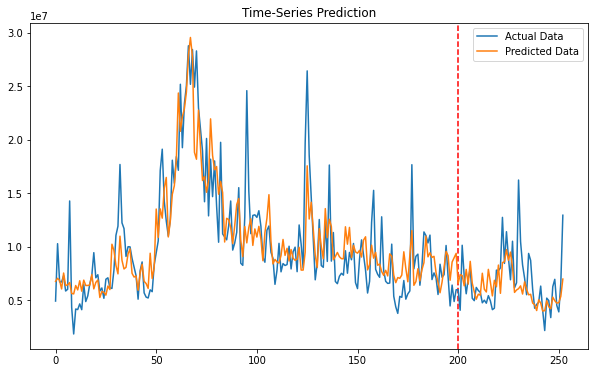

In [61]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200,c='r',linestyle='--')

plt.plot(label_y,label='Actual Data')
plt.plot(predicted,label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()
